# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [12]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [21]:
Sx = np.array([[1,0,-1],
                 [2,0,-2],
                 [1,0,-1]]) 
Sy = np.array([[1,2,1],
                 [0,0,0],
                 [-1,-2,-1]])
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],
                 [2,0,-2],
                 [1,0,-1]]) 
    Sy = np.array([[1,2,1],
                 [0,0,0],
                 [-1,-2,-1]])

    Gx = convolve2d(I, Sx, 'same')
    Gy = convolve2d(I, Sy, 'same')
    G = np.sqrt(Gx**2 + Gy**2)
    G = np.where(G < s, 0, 1)
    return G

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [14]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([[0,1,0],
                [1,-4,1],
                [0,1,0]])
    G = convolve2d(I, L, 'same')
    
    res = np.zeros(G.shape)
    
    for i in range(G.shape[0]-2):
        for j in range(G.shape[1]-2):
            iL = G[i:i+3,j:j+3]
            maxi = np.amax(iL)
            mini = np.amin(iL)
            if maxi>0 and mini<0 and maxi - mini > s:
                res[i][j] = 1
                
    return res

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

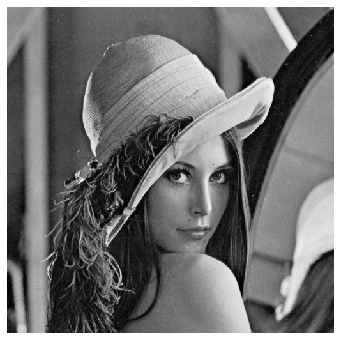

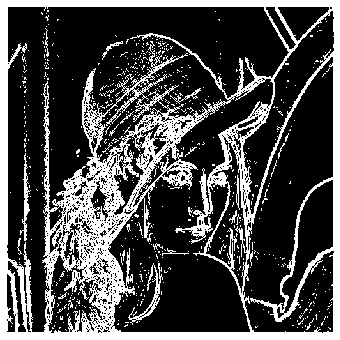

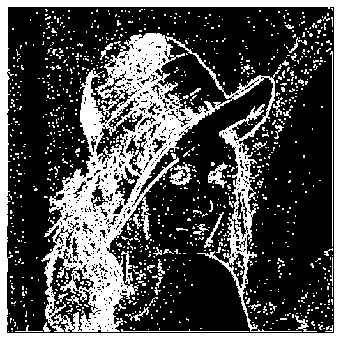

In [30]:
lenaImg = np.array(Image.open('img/lena.png'))
imshow(lenaImg)
imshow(SobelDetector(lenaImg, 70))
imshow(LaplacianDetector(lenaImg, 70))

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


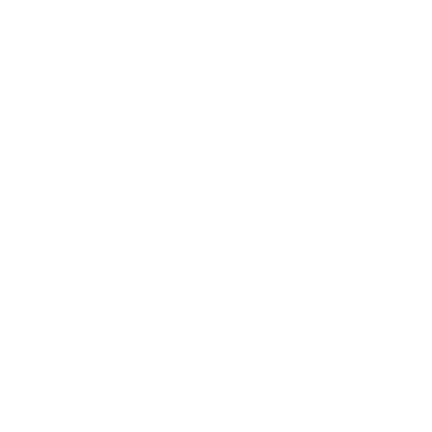

<IPython.core.display.Javascript object>


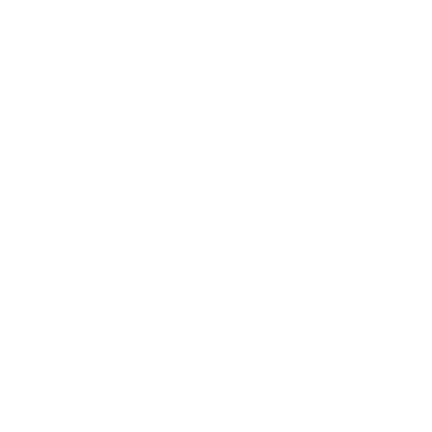

<IPython.core.display.Javascript object>


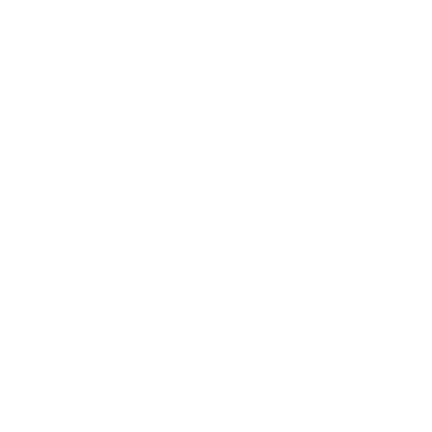

<IPython.core.display.Javascript object>


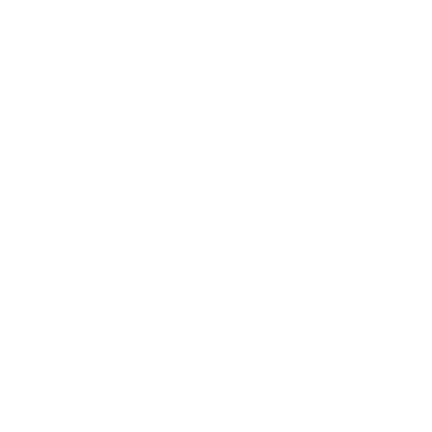

In [31]:
%matplotlib notebook
#### your answer below
toolsImg = np.array(Image.open('img/tools.png'))
imshow(toolsImg)
imshow_hot(orientation(convolve2d(toolsImg, Sx, 'same'),convolve2d(toolsImg, Sy, 'same'),SobelDetector(toolsImg,70)))


Explain the different values given to a pixel by `orientation()`:

The 4 values (angles) represent the direction in which the contrast is maximum.
Here, we notice that the yellow color represents the angle $0$ (horizontal oriantation), red is $\frac\pi2$ (vertical orientation), white is $\frac\pi4$,  and orange is $\frac{3\pi}4$ 

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [25]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    h=Ig.shape[0]
    l=Ig.shape[1]
    result=np.zeros((h,l))
    for i in range(1,h-1):
        for j in range(1,l-1):
            if(Ior[i][j]==3):
                if (Ig[i][j] >= Ig[i-1][j] and Ig[i][j] >= Ig[i+1][j] and Ig[i][j] > 0):
                    result[i][j]=Ig[i][j]
            if(Ior[i][j]==4):
                if (Ig[i][j] >= Ig[i-1][j-1] and Ig[i][j] >= Ig[i+1][j+1] and Ig[i][j] > 0):
                    result[i][j]=Ig[i][j]
            if(Ior[i][j]==1):
                if (Ig[i][j] >= Ig[i][j-1] and Ig[i][j] >= Ig[i][j+1] and Ig[i][j] > 0):
                    result[i][j]=Ig[i][j]
            if(Ior[i][j]==2):
                if (Ig[i][j] >= Ig[i+1][j-1] and Ig[i][j] >=Ig[i-1][j+1] and Ig[i][j] > 0):
                    result[i][j]=Ig[i][j]
    return result

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


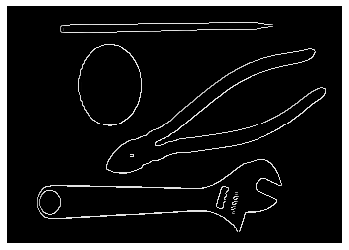

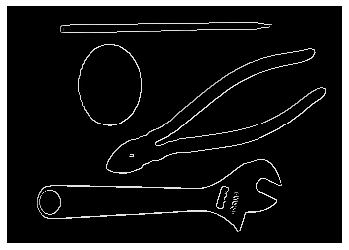

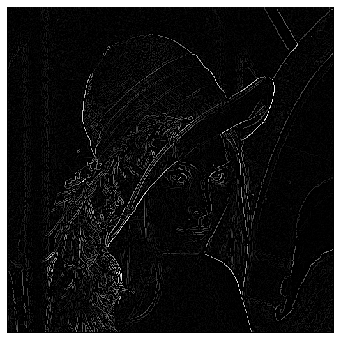

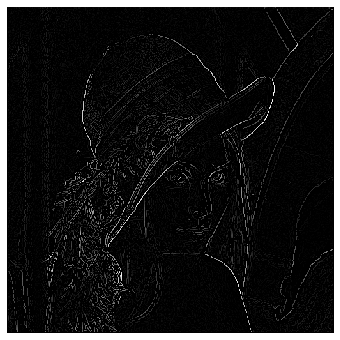

In [35]:
%matplotlib inline
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n = 2*np.ceil(3*sigma) + 1
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return  np.exp( (-x**2-y**2)/(2*sigma*sigma))

#tools
Ix=convolve2d(toolsImg,Sx,'same')
Iy=convolve2d(toolsImg,Sy,'same')
Ig=np.sqrt(Ix**2+Iy**2)

imshow(nms(Ig,orientation(Ix,Iy,Ig)))

toolsImg_gaussian=convolve2d(toolsImg,gaussianKernel(3),'same')
Ix_gaussian=convolve2d(toolsImg_gaussian,Sx,'same')
Iy_gaussian=convolve2d(toolsImg_gaussian,Sy,'same')
Ig_gaussian=np.sqrt(Ix**2+Iy**2)

imshow(nms(Ig_gaussian,orientation(Ix_gaussian,Iy_gaussian,Ig_gaussian)))

#lena
Ix=convolve2d(lenaImg,Sx,'same')
Iy=convolve2d(lenaImg,Sy,'same')
Ig=np.sqrt(Ix**2+Iy**2)

imshow(nms(Ig,orientation(Ix,Iy,Ig)))

lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(3),'same')
Ix_gaussian=convolve2d(lenaImg_gaussian,Sx,'same')
Iy_gaussian=convolve2d(lenaImg_gaussian,Sy,'same')
Ig_gaussian=np.sqrt(Ix**2+Iy**2)

imshow(nms(Ig_gaussian,orientation(Ix_gaussian,Iy_gaussian,Ig_gaussian)))

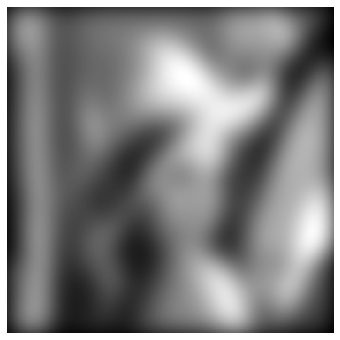

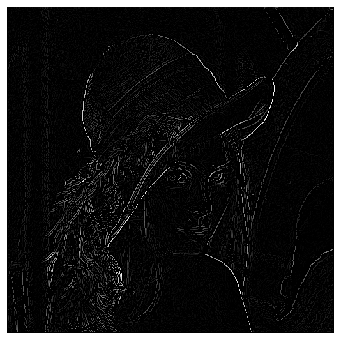

In [40]:
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(20),'same')
imshow(lenaImg_gaussian)
Ix_gaussian=convolve2d(lenaImg_gaussian,Sx,'same')
Iy_gaussian=convolve2d(lenaImg_gaussian,Sy,'same')
Ig_gaussian=np.sqrt(Ix**2+Iy**2)

imshow(nms(Ig_gaussian,orientation(Ix_gaussian,Iy_gaussian,Ig_gaussian)))

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Smoothing doesn't seem to have any effect on the edge detection process and on the size of edges. The result look almost identical with a sigma of 20 and with no blurring at all.

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

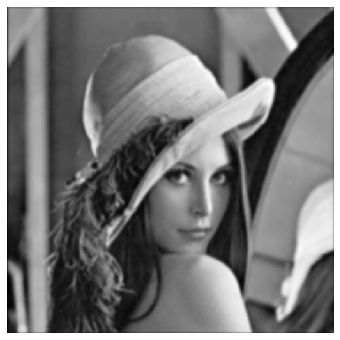

In [41]:
sig = 2
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(sig),'same')
imshow(lenaImg_gaussian)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

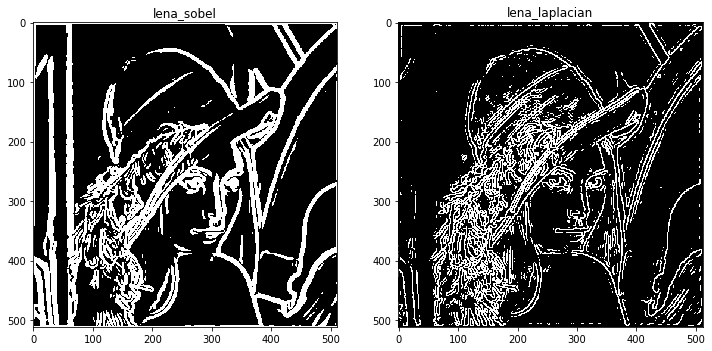

In [59]:
lena_sobel = SobelDetector(lenaImg_gaussian, 1000)
lena_laplacian = LaplacianDetector(lenaImg_gaussian, 50)
#imshow(lena_sobel)
#imshow(lena_laplacian)
niceDisplay14([lena_sobel, lena_laplacian], ['lena_sobel', 'lena_laplacian'])

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

Let's keep the threshold values at 1000 and 500 and let the sigma value vary from 3 to 15.
##### threshold values  :
tS = 1000
tL = 50

In [81]:
tS = 1000
tL = 50

## Effects on the Sobel detector 

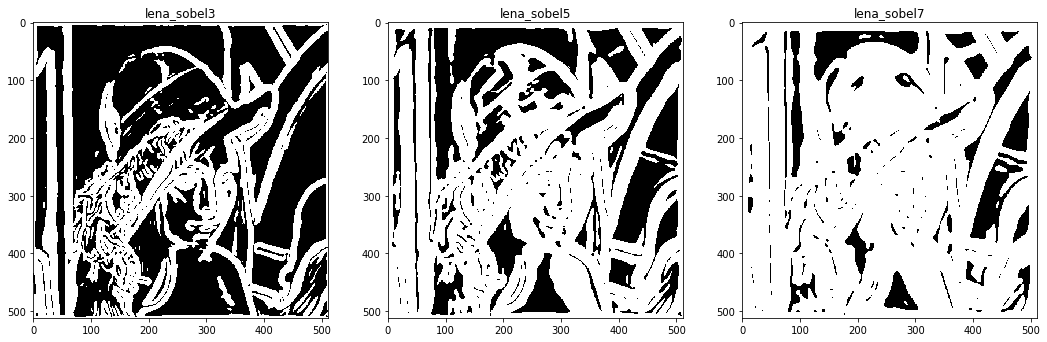

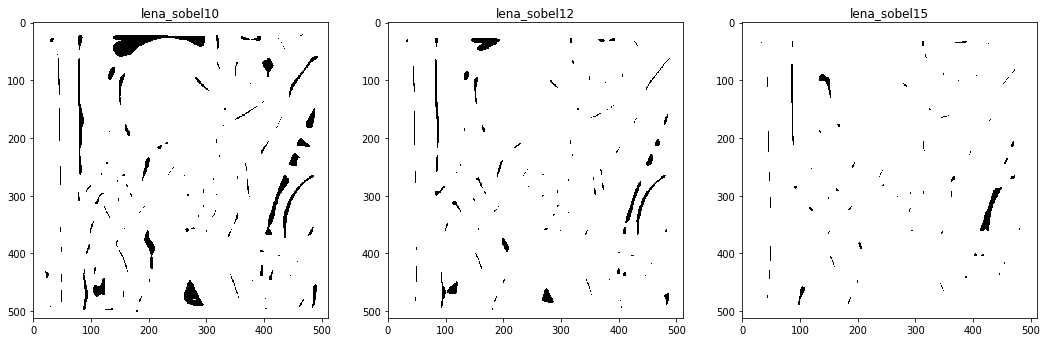

In [97]:
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(3),'same')
lena_sobel3 = SobelDetector(lenaImg_gaussian, tS)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(5),'same')
lena_sobel5 = SobelDetector(lenaImg_gaussian, tS)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(7),'same')
lena_sobel7 = SobelDetector(lenaImg_gaussian, tS)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(10),'same')
lena_sobel10 = SobelDetector(lenaImg_gaussian, tS)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(12),'same')
lena_sobel12 = SobelDetector(lenaImg_gaussian, tS)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(15),'same')
lena_sobel15 = SobelDetector(lenaImg_gaussian, tS)
niceDisplay14([lena_sobel3, lena_sobel5,lena_sobel7], ['lena_sobel3', 'lena_sobel5','lena_sobel7'])
niceDisplay14([lena_sobel10,lena_sobel12, lena_sobel15], ['lena_sobel10', 'lena_sobel12', 'lena_sobel15'])


##### Observations:
It looks like smoothing the image before-hand adds noise (meaning new false contours are added as sigma get bigger), and the "real" contours (the ones that are actually in the image) get thicker.
The combination of both those effects makes the image quickly unrecognisable.

## Effects on the Laplacian detector

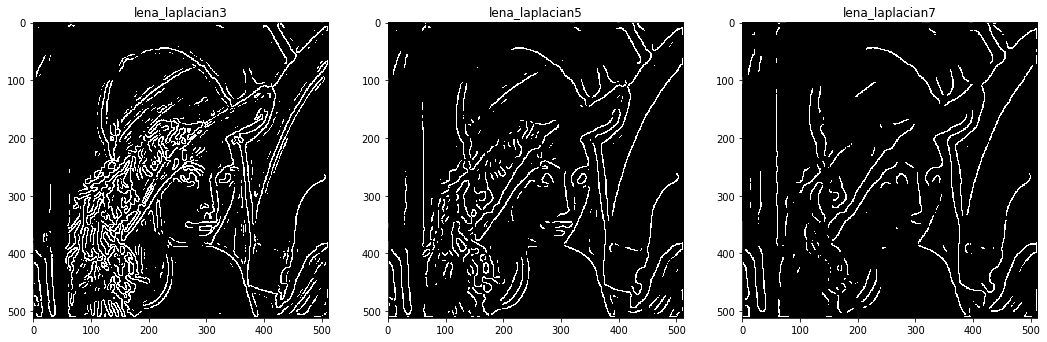

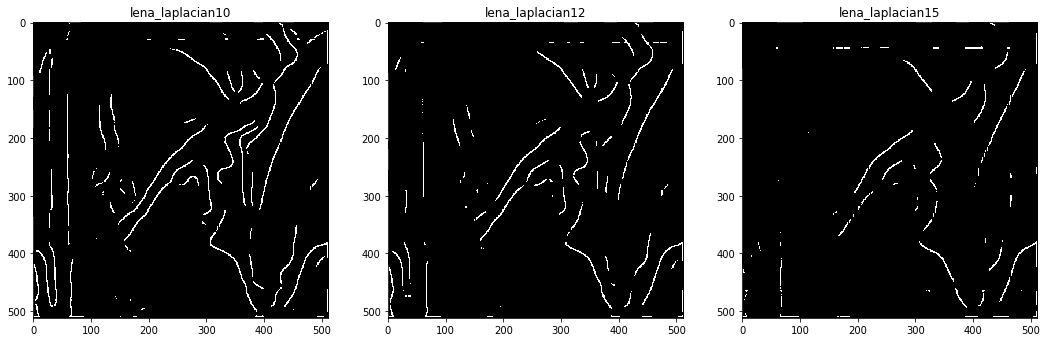

In [99]:
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(3),'same')
lena_laplacian3 = LaplacianDetector(lenaImg_gaussian, tL)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(5),'same')
lena_laplacian5 = LaplacianDetector(lenaImg_gaussian, tL)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(7),'same')
lena_laplacian7 = LaplacianDetector(lenaImg_gaussian, tL)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(10),'same')
lena_laplacian10 = LaplacianDetector(lenaImg_gaussian, tL)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(12),'same')
lena_laplacian12 = LaplacianDetector(lenaImg_gaussian, tL)
lenaImg_gaussian=convolve2d(lenaImg,gaussianKernel(15),'same')
lena_laplacian15 = LaplacianDetector(lenaImg_gaussian, tL)
niceDisplay14([lena_laplacian3, lena_laplacian5,lena_laplacian7], ['lena_laplacian3', 'lena_laplacian5','lena_laplacian7'])
niceDisplay14([lena_laplacian10, lena_laplacian12,lena_laplacian15], ['lena_laplacian10', 'lena_laplacian12','lena_laplacian15'])

##### Observations:
Here, the actual adges detected start to disappear as sigma gets bigger while other edges are falsly detected (like the horizontal line above Lena's hat starting to appear when sigma = 10 and that gets clearer as sigma gets bigger.)

Overrall, as sigma gets bigger, with the Sobel detector, we start to detect too many edges and with the Laplacian detector not enough edges.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

## Effects on the Sobel detector 

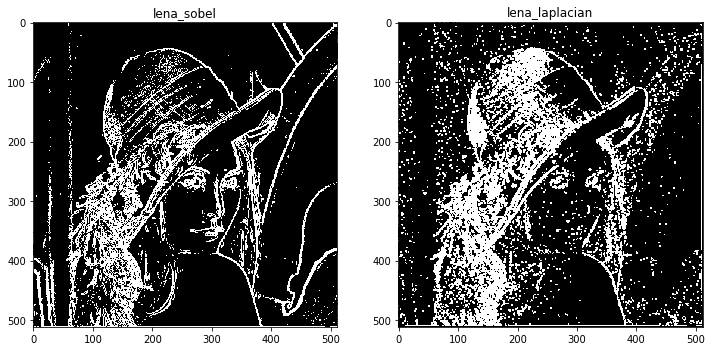

In [127]:
impRes = [[0,-1,0], [-1, 15, -1], [0, -1, 0]]
lenaImg_impRes=convolve2d(lenaImg,impRes,'same')
lena_sobel = SobelDetector(lenaImg_impRes, tS)

impRes = [[0,-1,0], [-1, 13, -1], [0, -1, 0]]
lenaImg_impRes=convolve2d(lenaImg,impRes,'same')
lena_laplacian = LaplacianDetector(lenaImg_impRes, tS)

niceDisplay14([lena_sobel, lena_laplacian], ['lena_sobel', 'lena_laplacian'])


5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.